In [1]:
from dataset import *
from dataset.raw_data import air_quality_test_data, air_quality_train_data
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

/home/hoang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x = torch.rand(5, 4)

torch.stack((x, x, x), dim=1).shape

torch.Size([5, 3, 4])

In [3]:
from utils.functional import scale_softmax

In [4]:
x = torch.tensor([0.1, 0.01, 0.4, 0.05], dtype=torch.float)

torch.softmax(x, dim=0)

tensor([0.2372, 0.2168, 0.3202, 0.2257])

In [6]:
from hydra import initialize, compose
import os
with initialize(version_base=None, config_path=os.path.relpath("/home/hoang/Documents/CodeSpace/air-quality-forecasting/config/model")):
  cfg = compose(config_name="gagnn.yaml")

In [7]:
dts = AirQualityDataset2(
        "../data",
        normalize_mean={"humidity":0, "temperature": 0, "PM2.5": 0},
        normalize_std={"humidity": 1, "temperature": 1, "PM2.5": 1},
        # normalize_mean=cfg.data.normalize_mean,
        # normalize_std=cfg.data.normalize_std,
        droprate=0.5,
        fillnan_fn=lambda x: x.interpolate(option="spline").bfill()
    )

In [8]:
dts[0]["src_locs"].std(0)

tensor([0.0553, 0.0131])

In [9]:
dts[0]["features"][0]

tensor([[74.0300, 31.5300, 32.8500,  ...,  0.8710,  0.4167,  0.2917],
        [73.3200, 31.4800, 32.1200,  ...,  0.8710,  0.4167,  0.2917],
        [78.8000, 30.8800, 36.8300,  ...,  0.8710,  0.4167,  0.2917],
        ...,
        [80.1900, 33.5100, 37.1800,  ...,  0.0968,  0.5000,  0.2917],
        [72.7300, 34.9400, 37.9900,  ...,  0.0968,  0.5000,  0.2917],
        [68.7100, 36.0200, 36.6800,  ...,  0.0968,  0.5000,  0.2917]])

In [10]:
dts[0]["src_nexts"][0]

tensor([34.5100, 34.5300, 33.5700, 32.8900, 35.3300, 36.5400, 46.4200, 49.2300,
        64.2100, 63.9500, 59.7800, 44.6400, 35.2800, 29.8800, 29.2300, 29.0300,
        27.9500, 27.7200, 30.0300, 33.4400, 35.5800, 38.3600, 38.7200, 37.0300])

In [11]:
def get_neighbors(dt, num: int = 5):
    y = dt["gt_target"]
    x = dt["src_nexts"]

    errs = []
    for i in range(x.size(0)):
        err = ((y - x[i]) / y).abs().mean()
        errs.append(err.item())

    return dt["target_idx"], errs

In [12]:
corr = []
for i in range(4):
    l = []
    for j in range(11):
        l.append(0)
    corr.append(l)

for i in range(len(dts)):
    tar_idx, errs = get_neighbors(dts[i], num=5)

    for src_idx in range(11):
        corr[tar_idx][src_idx] += errs[src_idx]

corr = torch.tensor(corr)

KeyError: 'gt_target'

In [ ]:
torch.topk(corr, k=7, largest=True).indices

tensor([[ 3, 10,  9,  1,  2,  8,  6],
        [ 3, 10,  9,  1,  5,  4,  6],
        [ 3, 10,  2,  9,  1,  5,  4],
        [ 8,  9,  7,  3, 10,  2,  6]])

In [ ]:
locs = torch.cat((dts.data["X_locs"], dts.data["y_locs"]), dim=0)
mean_ = locs.min(0).values
std_ = (locs.max(0).values - locs.min(0).values)

In [ ]:
std_

tensor([0.1794, 0.0830])

In [ ]:
(locs - mean_) / std_

tensor([[0.9527, 0.7200],
        [0.7023, 0.8667],
        [0.5786, 0.8568],
        ...,
        [0.5488, 0.0000],
        [0.8056, 0.7781],
        [0.6650, 0.5654]])

In [ ]:
import utils.functional as F

def predict(i: int, top_k: int = None, beta=1.0, fill_corr=True):
    corr = torch.tensor([[ 3, 10,  9,  1,  2,  8,  6],
        [ 3, 10,  9,  1,  5,  4,  6],
        [ 3, 10,  2,  9,  1,  5,  4],
        [ 8,  9,  7,  3, 10,  2,  6]])
    dt = dts[i]

    if fill_corr:
        tar_idx = dt["target_idx"]
        masks = corr[tar_idx]

        src_locs = dt["src_locs"][masks][None, ...]
        tar_loc = dt["tar_loc"][None, None, :]
        src_vals = dt["src_nexts"][masks]
    else:
        src_masks = dt["src_masks"]

        src_locs = dt["src_locs"][src_masks][None, ...]
        tar_loc = dt["tar_loc"][None, None, :]
        src_vals = dt["src_nexts"][src_masks]

    if top_k is None or top_k > src_locs.size(1):
        top_k = src_locs.size(1)
    
    dists = F.euclidean_distances(src_locs, tar_loc).squeeze()
    keep_ids = torch.topk(dists, k=top_k, largest=False).indices

    src_locs = src_locs[:, keep_ids]
    # pm25_idx = dts.feature_cols.index("PM2.5")
    src_vals = src_vals[keep_ids]
    tar_val = dt["gt_target"]


    weights = F.inverse_distance_weighted(src_locs, tar_loc, beta=beta).squeeze(0)
    pred = (src_vals * weights).sum(0)
    
    return pred, tar_val, dt["target_idx"]

In [ ]:
errors = [[], [], [], []]
for i in range(len(dts)):
    y_hat, y, tar_idx = predict(i, top_k=7)

    err = ((y_hat - y) / y).abs().median()
    # err = (pred - tar_val).abs().mean()
    errors[tar_idx].append(err)

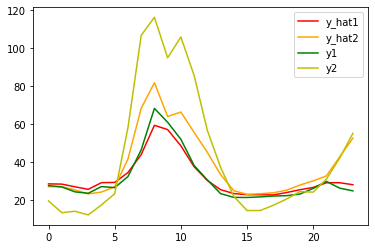

In [ ]:
i = 3
beta = 2
top_k = None
fill_corr = True
y_hat1, y1, _ = predict(i, beta=beta, top_k=top_k, fill_corr=fill_corr)
y_hat2, y2, _ = predict(i + 1, beta=beta, top_k=top_k, fill_corr=fill_corr)

plt.plot(y_hat1, "r")
plt.plot(y_hat2, "orange")
plt.plot(y1, "g")
plt.plot(y2, "y")
plt.legend([
    "y_hat1", "y_hat2",
    "y1", "y2"
])

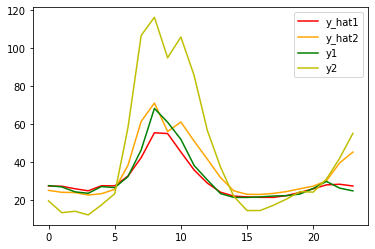

In [ ]:
i = 3
beta = 1
top_k = 6
fill_corr = False
y_hat1, y1, _ = predict(i, beta=beta, top_k=top_k, fill_corr=fill_corr)
y_hat2, y2, _ = predict(i + 1, beta=beta, top_k=top_k, fill_corr=fill_corr)

plt.plot(y_hat1, "r")
plt.plot(y_hat2, "orange")
plt.plot(y1, "g")
plt.plot(y2, "y")
plt.legend([
    "y_hat1", "y_hat2",
    "y1", "y2"
])

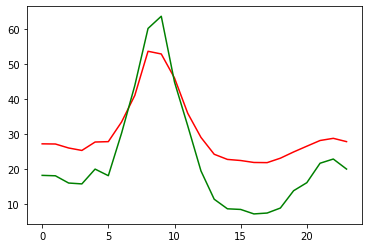

In [ ]:
y_hat, y, _ = predict(2, beta=1.0, fill_corr=True)
plt.plot(y_hat, "r")
plt.plot(y, "g")

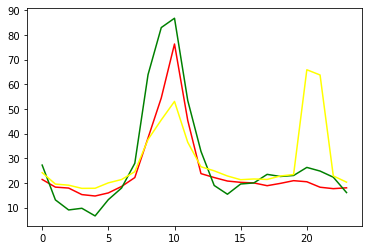

In [36]:
pm25idx = dts.feature_cols.index("PM2.5")
viewidx = 3
dt = dts[1]
pm25 = dt["features"][..., pm25idx].reshape(11, 7, 24)
plt.plot(pm25[2, viewidx], "r")
plt.plot(pm25[3, viewidx], "g")
plt.plot(pm25[10, viewidx], "yellow")
# plt.plot(dt["src_nexts"][7])

In [ ]:
# avg_errs = [sum(errors[i]) / (len(errors[i]) + 1e-8) for i in range(4)]
colors = ["r", "b", "g", "y"]
for i in range(4):
    plt.plot(errors[i], colors[i])

plt.legend([
    "S0000328-Luong The Vinh",
    "S0000367-To Hieu",
    "S0000339-Kim Ma",
    "S0000182-Truong THCS Trung Hoa"
])
plt.show()

NameError: name 'errors' is not defined

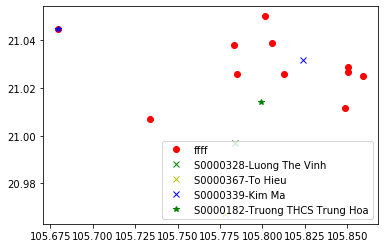

In [ ]:
plt.plot(dts.data["X_locs"][:, 0], dts.data["X_locs"][:, 1], "ro")
for i in range(4):
    colors = ["gx", "yx", "bx", "g*"]
    plt.plot(dts.data["y_locs"][i, 0], dts.data["y_locs"][i, 1], colors[i])
plt.plot(dts.data["X_locs"][7, 0], dts.data["X_locs"][7, 1], "b*")
plt.legend([
    "ffff",
    "S0000328-Luong The Vinh",
    "S0000367-To Hieu",
    "S0000339-Kim Ma",
    "S0000182-Truong THCS Trung Hoa"
], loc="lower right")

In [ ]:
dt["src_nexts"].shape

torch.Size([11, 24])

In [ ]:
dt["features"][4][:11].shape

torch.Size([11, 7])

In [ ]:
dt["tar_loc"], dt["target_idx"]

(tensor([105.8241,  21.0317]), 2)

In [ ]:
dt["gt_target"]

tensor([ 21.7400,  22.0600,  17.5300,  17.0200,  22.0600,  22.3300,  32.6200,
         68.2600, 108.1800,  86.6500,  69.7300,  43.5700,  25.9800,  19.4300,
         15.1700,  15.9000,  15.0100,  14.7300,  18.1400,  18.6600,  26.1100,
         30.2800,  20.8600,  18.1600])

In [ ]:
from torch.utils.data import DataLoader
loader = DataLoader(dts, batch_size=32)

for batch in loader:
    print(batch["mask"])
    break

KeyError: 'mask'

In [ ]:
from model.layers import InverseDistanceAttention

/home/hoang/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [ ]:
dt = dts[4]

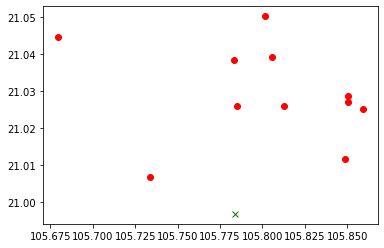

In [ ]:
plt.plot(dt["src_locs"][:, 0], dt["src_locs"][:, 1], "ro")
plt.plot(dt["tar_loc"][None, 0], dt["tar_loc"][None, 1], "gx")

In [ ]:
src_grids, tar_grid = InverseDistanceAttention({"attn_dropout": 0.1}, 4).locs_to_grid(dt["src_locs"].unsqueeze(0), dt["tar_loc"][None, None, :])

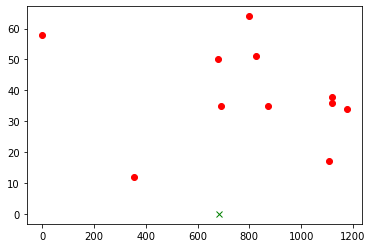

In [ ]:
plt.plot(src_grids[0, :, 0], src_grids[0, :, 1], "ro")
plt.plot(tar_grid[0, :, 0], tar_grid[0, :, 1], "gx")